<a href="https://colab.research.google.com/github/AryanGupta0419/PytorchTutorial/blob/main/DLLAB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:14<00:00, 11.5MB/s]


In [4]:
class CNNWithBN(nn.Module):
    def __init__(self):
        super(CNNWithBN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNWithBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
num_epochs = 10
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (batch_idx + 1) % 100 == 0:
            train_acc = 100 * correct_train / total_train
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Train Acc: {train_acc:.2f}%")

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Completed -> Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")


Epoch [1/10], Batch [100/391], Train Acc: 82.20%
Epoch [1/10], Batch [200/391], Train Acc: 81.89%
Epoch [1/10], Batch [300/391], Train Acc: 81.88%
Epoch [1/10] Completed -> Loss: 0.5279, Train Acc: 81.77%, Test Acc: 83.94%
Epoch [2/10], Batch [100/391], Train Acc: 82.55%
Epoch [2/10], Batch [200/391], Train Acc: 82.57%
Epoch [2/10], Batch [300/391], Train Acc: 82.58%
Epoch [2/10] Completed -> Loss: 0.4991, Train Acc: 82.53%, Test Acc: 84.71%
Epoch [3/10], Batch [100/391], Train Acc: 82.87%
Epoch [3/10], Batch [200/391], Train Acc: 82.96%
Epoch [3/10], Batch [300/391], Train Acc: 82.93%
Epoch [3/10] Completed -> Loss: 0.4827, Train Acc: 83.13%, Test Acc: 86.20%
Epoch [4/10], Batch [100/391], Train Acc: 85.05%
Epoch [4/10], Batch [200/391], Train Acc: 84.46%
Epoch [4/10], Batch [300/391], Train Acc: 84.15%
Epoch [4/10] Completed -> Loss: 0.4555, Train Acc: 84.16%, Test Acc: 86.11%
Epoch [5/10], Batch [100/391], Train Acc: 84.73%
Epoch [5/10], Batch [200/391], Train Acc: 84.89%
Epoch [5/1

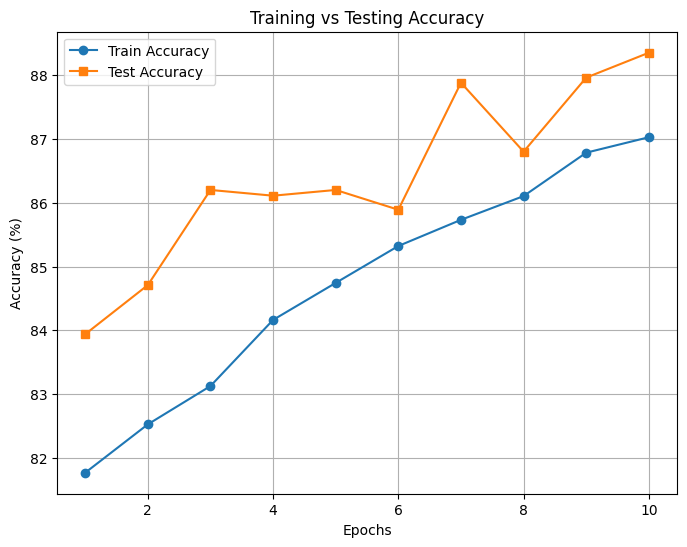

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_acc_list, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Testing Accuracy")
plt.legend()
plt.grid(True)
plt.show()